<a href="https://colab.research.google.com/github/ArielFix/Intro2DL/blob/main/Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3: Image Classification

**Assignment Responsible**: Natalie Lang.

In this assignment, we will build a convolutional neural network that can predict 
whether two shoes are from the **same pair** or from two **different pairs**.
This kind of application can have real-world applications: for example to help
people who are visually impaired to have more independence.

We will explore two convolutional architectures. While we will give you starter
code to help make data processing a bit easier, in this assignment you have a chance to build your neural network all by yourself. 

You may modify the starter code as you see fit, including changing the signatures of
functions and adding/removing helper functions. However, please make sure that we can understand what you are doing and why.
 

In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

## Question 1. Data (20%)

Download the data from https://www.dropbox.com/s/6gdcpmfddojrl8o/data.rar?dl=0.

Unzip the file. There are three
main folders: `train`, `test_w` and `test_m`. Data in `train` will be used for
training and validation, and the data in the other folders will be used for testing.
This is so that the entire class will have the same test sets. The dataset is comprised of triplets of pairs, where each such triplet of image pairs was taken in a similar setting (by the same person).

We've separated `test_w` and `test_m` so that we can track our model performance 
for women's shoes and men's shoes separately. Each of the test sets contain images of either exclusively men's shoes or women's
shoes.

Upload this data to Google Colab.
Then, mount Google Drive from your Google Colab notebook:

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


After you have done so, read this entire section 
before proceeding. There are right and wrong ways of
processing this data. If you don't make the correct choices, you may find
yourself needing to start over.
Many machine learning projects fail because of the lack of care taken during
the data processing stage.

### Part (a) -- 8%

Load the training and test data, and separate your training data into training and validation.
Create the numpy arrays `train_data`, `valid_data`, `test_w` and `test_m`, all of which should
be of shape `[*, 3, 2, 224, 224, 3]`. The dimensions of these numpy arrays are as follows:

- `*` - the number of triplets allocated to train, valid, or test
- `3` - the 3 pairs of shoe images in that triplet
- `2` - the left/right shoes
- `224` - the height of each image
- `224` - the width of each image
- `3` - the colour channels

So, the item `train_data[4,0,0,:,:,:]` should give us the left shoe of the first image of the fifth person.The item `train_data[4,0,1,:,:,:]`  should be the right shoe in the same pair. 
The item `train_data[4,1,1,:,:,:]`  should be the right shoe in a different pair of that same person.

When you first load the images using (for example) `plt.imread`, you may see a numpy array of shape
`[224, 224, 4]` instead of `[224, 224, 3]`. That last channel is what's called the alpha channel for transparent
pixels, and should be removed. 
The pixel intensities are stored as an integer between 0 and 255.
Make sure you normlize your images, namely, divide the intensities by 255 so that you have floating-point values between 0 and 1. Then, subtract 0.5
so that the elements of `train_data`, `valid_data` and `test_data` are between -0.5 and 0.5.
**Note that this step actually makes a huge difference in training!**

This function might take a while to run; it can takes several minutes to just
load the files from Google Drive.  If you want to avoid
running this code multiple times, you can save 
your numpy arrays and load it later:
https://docs.scipy.org/doc/numpy/reference/generated/numpy.save.html

In [3]:
# Your code goes here. Make sure it does not get cut off
# You can use the code below to help you get started. You're welcome to modify
# the code or remove it entirely: it's just here so that you don't get stuck
# reading files

import glob
path = "/content/gdrive/My Drive/MSc/Courses/Into to Deep Learnig/Assignments/3/data/train/*.jpg" # TODO - UPDATE ME!
images = {}
for file in glob.glob(path):
    filename = file.split("/")[-1]   # get the name of the .jpg file
    img = plt.imread(file)           # read the image as a numpy array
    images[filename] = img[:, :, :3] # remove the alpha channel



In [4]:
frame = pandas.DataFrame(images.items())
frame.sort_values([0], axis=0, inplace=True)
frame.head(10)

,0,1
592,u001_1_left_w.jpg,"[[[129, 111, 91], [131, 113, 93], [133, 115, 9..."
420,u001_1_right_w.jpg,"[[[127, 111, 95], [124, 108, 92], [124, 108, 9..."
309,u001_2_left_w.jpg,"[[[106, 93, 76], [99, 86, 69], [98, 85, 68], [..."
542,u001_2_right_w.jpg,"[[[108, 93, 74], [109, 94, 75], [111, 96, 77],..."
9,u001_3_left_w.jpg,"[[[117, 101, 86], [117, 101, 86], [119, 103, 8..."
384,u001_3_right_w.jpg,"[[[117, 101, 86], [116, 100, 85], [115, 99, 84..."
186,u003_1_left_m.jpg,"[[[85, 66, 36], [89, 68, 41], [87, 66, 39], [8..."
428,u003_1_right_m.jpg,"[[[90, 69, 40], [91, 70, 41], [91, 70, 41], [9..."
480,u003_2_left_m.jpg,"[[[107, 84, 40], [108, 85, 43], [105, 82, 40],..."
102,u003_2_right_m.jpg,"[[[107, 78, 38], [107, 78, 38], [107, 78, 38],..."


In [5]:
array = []
[array.append(f) for f in frame[1]]
# array.reshape(-1,3,2,224,224,3)
train_data = np.array(array).reshape(-1,3,2,224,224,3)/255 - 0.5
train_data.shape

(112, 3, 2, 224, 224, 3)

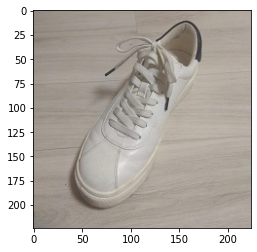

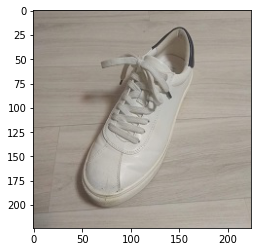

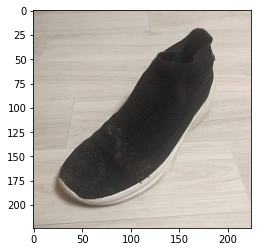

In [6]:
# Run this code, include the image in your PDF submission
plt.figure()
plt.imshow(train_data[4,0,0,:,:,:]+0.5) # left shoe of first pair submitted by 5th student
plt.figure()
plt.imshow(train_data[4,0,1,:,:,:]+0.5) # right shoe of first pair submitted by 5th student
plt.figure()
plt.imshow(train_data[4,1,1,:,:,:]+0.5) # right shoe of second pair submitted by 5th student

### Part (b) -- 4%

Since we want to train a model that determines whether two shoes come from the **same**
pair or **different** pairs, we need to create some labelled training data.
Our model will take in an image, either consisting of two shoes from the **same pair**
or from **different pairs**. So, we'll need to generate some *positive examples* with
images containing two shoes that *are* from the same pair, and some *negative examples* where 
images containing two shoes that *are not* from the same pair.
We'll generate the *positive examples* in this part, and the *negative examples* in the next part.

Write a function `generate_same_pair()` that takes one of the data sets that you produced
in part (a), and generates a numpy array where each pair of shoes in the data set is
concatenated together. In particular, we'll be concatenating together images of left
and right shoes along the **height** axis. Your function `generate_same_pair` should
return a  numpy array of shape `[*, 448, 224, 3]`.

While at this stage we are working with numpy arrays, later on, we will need to convert this numpy array into a PyTorch tensor with shape
`[*, 3, 448, 224]`. For now, we'll keep the RGB channel as the last dimension since
that's what `plt.imshow` requires.

(112, 3, 2, 224, 224, 3)
(336, 448, 224, 3)


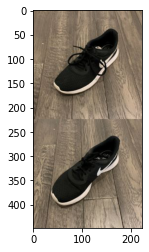

In [7]:
# Your code goes here
def generate_same_pair(train_data):
  return train_data.copy().reshape(-1,448,224,3)

# Run this code, include the result with your PDF submission
print(train_data.shape) # if this is [N, 3, 2, 224, 224, 3]
print(generate_same_pair(train_data).shape) # should be [N*3, 448, 224, 3]
plt.imshow((generate_same_pair(train_data)[0]+0.5)) # should show 2 shoes from the same pair

### Part (c) -- 4%

Write a function `generate_different_pair()` that takes one of the data sets that
you produced in part (a), and generates a numpy array in the same shape as part (b).
However, each image will contain 2 shoes from a **different** pair, but submitted
by the **same student**. Do this by jumbling the 3 pairs of shoes submitted by 
each student.

Theoretically, for each person (triplet of pairs), there are 6 different combinations
of "wrong pairs" that we could produce. To keep our data set *balanced*, we will
only produce **three** combinations of wrong pairs per unique person.
In other words,`generate_same_pairs` and `generate_different_pairs` should
return the same number of training examples.

(112, 3, 2, 224, 224, 3)
(336, 448, 224, 3)


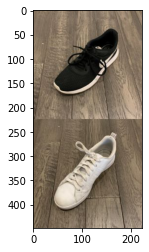

In [8]:
# Your code goes here
def generate_different_pair(train_data):
  data = train_data.copy()
  mix_pairs = [1,2,0]
  data[:,:,1,:,:,:] = data[:,mix_pairs, 1, :,:,:]

  return data.reshape(-1,448,224,3)

# Run this code, include the result with your PDF submission
print(train_data.shape) # if this is [N, 3, 2, 224, 224, 3]
print(generate_different_pair(train_data).shape) # should be [N*3, 448, 224, 3]
plt.imshow(generate_different_pair(train_data)[0]+0.5) # should show 2 shoes from different pairs

In [ ]:
v = generate_different_pair(train_data).reshape(-1,224,224,6)
print(v.shape)
# v = v.reshape(-1,224,224,3)
# print(v.shape)
# v = v.reshape(-1,224,224,6)
# v.shape

(336, 224, 224, 6)


### Part (d) -- 2%

Why do we insist that the different pairs of shoes still come from the same
person?  (Hint: what else do images from the same person have in common?)

**Write your explanation here:**

The images contains background and user's camera properties which will affect the inference.
Also, we can assume that the same shoe might be purchased by differen peoples and by creating the different pairs from the same person we can have higher confidence that we won;t get matching pairs in the differen pairs data

### Part (e) -- 2%

Why is it important that our data set be *balanced*? In other words suppose we created
a data set where 99% of the images are of shoes that are *not* from the same pair, and 
1% of the images are shoes that *are* from the same pair. Why could this be a problem?

**Write your explanation here:**

If the data set wouldn't be balanced the model might learn to predict a certain constant answer.
For example, if 99% will not be from the same pair, the model will reach 99% accuracy just for predicting that the pair isn't match and will alawys predict unmatched pair

## Question 2. Convolutional Neural Networks (25%)

Before starting this question, we recommend reviewing the lecture and its associated example notebook on CNNs.

In this section, we will build two CNN models in PyTorch.

### Part (a) -- 9%

Implement a CNN model in PyTorch called `CNN` that will take images of size
$3 \times 448 \times 224$, and classify whether the images contain shoes from
the same pair or from different pairs.

The model should contain the following layers:

- A convolution layer that takes in 3 channels, and outputs $n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A second convolution layer that takes in $n$ channels, and outputs $2\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A third convolution layer that takes in $2\cdot n$ channels, and outputs $4\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A fourth convolution layer that takes in $4\cdot n$ channels, and outputs $8\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A fully-connected layer with 100 hidden units
- A fully-connected layer with 2 hidden units

Make the variable $n$ a parameter of your CNN. You can use either $3 \times 3$ or $5 \times 5$
convolutions kernels. Set your padding to be `(kernel_size - 1) / 2` so that your feature maps
have an even height/width.

Note that we are omitting in our description certain steps that practitioners will typically not mention,
like ReLU activations and reshaping operations. Use the example presented in class to figure out where they are.

In [40]:
class CNN(nn.Module):
    def __init__(self, n=4):
        super(CNN, self).__init__()
        # TODO: complete this method
        self.n = n
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=n, padding='same', kernel_size=(3, 121))
        self.conv2 = nn.Conv2d(in_channels=n, out_channels=2*n, padding='same', kernel_size=(5, 71))
        self.conv3 = nn.Conv2d(in_channels=2*n, out_channels=4*n, padding='same', kernel_size=(5, 51))
        self.conv4 = nn.Conv2d(in_channels=4*n, out_channels=8*n, padding='same', kernel_size=(5, 21))
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(8*n*14*28, 100)
        self.fc2 = nn.Linear(100, 2)
           
    # TODO: complete this class
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.max_pool(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.max_pool(x)
        x = self.conv3(x)
        x = nn.functional.relu(x)
        x = self.max_pool(x)
        x = self.conv4(x)
        x = nn.functional.relu(x)
        x = self.max_pool(x)
        x = x.view(-1, 8*self.n*14*28)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        x = nn.functional.log_softmax(x, dim=1)
        return x

### Part (b) -- 8%

Implement a CNN model in PyTorch called `CNNChannel` that contains the same layers as
in the Part (a), but with one crucial difference: instead of starting with an image
of shape $3 \times 448 \times 224$, we will first manipulate the image so that the
left and right shoes images are concatenated along the **channel** dimension.

<img src="https://drive.google.com/uc?id=1B59VE43X-6Dw3ag-9Ndn6vPEzbnFem8K" width="400px" />


Complete the manipulation in the `forward()` method (by slicing and using
the function `torch.cat`). The input to the first convolutional layer
should have 6 channels instead of 3 (input shape $6 \times 224 \times 224$).

Use the same hyperparameter choices as you did in part (a), e.g. for the kernel size,
choice of downsampling, and other choices.

In [10]:
class CNNChannel(nn.Module):
    def __init__(self, n=4):
        super(CNNChannel, self).__init__()
        # TODO: complete this method
        self.n = n
        self.conv1 = nn.Conv2d(in_channels=6,out_channels=n, padding='same', kernel_size=11)
        self.conv2 = nn.Conv2d(in_channels=n, out_channels=2*n, padding='same', kernel_size=11)
        self.conv3 = nn.Conv2d(in_channels=2*n, out_channels=4*n, padding='same', kernel_size=7)
        self.conv4 = nn.Conv2d(in_channels=4*n, out_channels=8*n, padding='same', kernel_size=5)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(8*n*14*14, 100)
        self.fc2 = nn.Linear(100, 2)
           
    # TODO: complete this class
    def forward(self, x, verbose=False):
        x = self.conv1(x.reshape(-1,6,224,224))
        x = nn.functional.relu(x)
        x = self.max_pool(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.max_pool(x)
        x = self.conv3(x)
        x = nn.functional.relu(x)
        x = self.max_pool(x)
        x = self.conv4(x)
        x = nn.functional.relu(x)
        x = self.max_pool(x)
        x = x.view(-1, 8*self.n*14*14)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        x = nn.functional.log_softmax(x, dim=1)
        return x

## Part (c) -- 4%

The two models are quite similar, and should have almost the same number of parameters.
However, one of these models will perform better, showing that architecture choices **do**
matter in machine learning. Explain why one of these models performs better.

**Write your explanation here:**

## Part (d) -- 4%

The function `get_accuracy` is written for you. You may need to modify this
function depending on how you set up your model and training.

Unlike in the previous assignment, her we will separately compute the model accuracy on the
positive and negative samples.  Explain why we may wish to track the false positives and false negatives separately.

**Write your explanation here:**

In [11]:
def get_accuracy(model, data, batch_size=50):
    """Compute the model accuracy on the data set. This function returns two
    separate values: the model accuracy on the positive samples,
    and the model accuracy on the negative samples.

    Example Usage:

    >>> model = CNN() # create untrained model
    >>> pos_acc, neg_acc= get_accuracy(model, valid_data)
    >>> false_positive = 1 - pos_acc
    >>> false_negative = 1 - neg_acc
    """

    model.eval()
    n = data.shape[0]

    data_pos = generate_same_pair(data)      # should have shape [n * 3, 448, 224, 3]
    data_neg = generate_different_pair(data) # should have shape [n * 3, 448, 224, 3]

    pos_correct = 0
    for i in range(0, len(data_pos), batch_size):
        xs = torch.Tensor(data_pos[i:i+batch_size]).transpose(1, 3).to(device)
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.to("cpu").detach().numpy()
        pos_correct += (pred == 1).sum()
    
    neg_correct = 0
    for i in range(0, len(data_neg), batch_size):
        xs = torch.Tensor(data_neg[i:i+batch_size]).transpose(1, 3).to(device)
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.to("cpu").detach().numpy()
        neg_correct += (pred == 0).sum()

    return pos_correct / (n * 3), neg_correct / (n * 3)

## Question 3. Training (40%)

Now, we will write the functions required to train the model. 

Although our task is a binary classification problem, we will still use the architecture
of a multi-class classification problem. That is, we'll use a one-hot vector to represent
our target (like we did in the previous assignment). We'll also use `CrossEntropyLoss` instead of
`BCEWithLogitsLoss` (this is a standard practice in machine learning because
this architecture often performs better).

### Part (a) -- 22%

Write the function `train_model` that takes in (as parameters) the model, training data,
validation data, and other hyperparameters like the batch size, weight decay, etc.
This function should be somewhat similar to the training code that you wrote
in Assignment 2, but with a major difference in the way we treat our training data.

Since our positive (shoes of the same pair) and negative (shoes of different pairs) training sets are separate, it is actually easier for
us to generate separate minibatches of positive and negative training data.
 In
each iteration, we'll take `batch_size / 2` positive samples and `batch_size / 2`
negative samples. We will also generate labels of 1's for the positive samples,
and 0's for the negative samples.

Here is what your training function should include:

- main training loop; choice of loss function; choice of optimizer
- obtaining the positive and negative samples
- shuffling the positive and negative samples at the start of each epoch
- in each iteration, take `batch_size / 2` positive samples and `batch_size / 2` negative samples
  as our input for this batch
- in each iteration, take `np.ones(batch_size / 2)` as the labels for the positive samples, and 
  `np.zeros(batch_size / 2)` as the labels for the negative samples
- conversion from numpy arrays to PyTorch tensors, making sure that the input has dimensions $N \times C \times H \times W$ (known as NCHW tensor), where $N$ is the number of images batch size, $C$ is the number of channels, $H$ is the height of the image, and $W$ is the width of the image. 
- computing the forward and backward passes 
- after every epoch, report the accuracies for the training set and validation set
- track the training curve information and plot the training curve

It is also recommended to checkpoint your model (save a copy) after every epoch, as we did in Assignment 2.

In [12]:
from torch._C import dtype
# Write your code here
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

def get_batch(pos, neg):
  data = torch.concatenate([pos,neg], dim=0)
  label = torch.concatenate([torch.ones(pos.shape[0]), torch.zeros(neg.shape[0])], dim = 0)
  return data, label

def run_pytorch_gradient_descent(model,
                                 train_data,
                                 validation_data,
                                 batch_size=100,
                                 learning_rate=0.001,
                                 weight_decay=0,
                                 max_iters=1000,
                                 checkpoint_path=None):
    """
    Train the PyTorch model on the dataset `train_data`, reporting
    the validation accuracy on `validation_data`, for `max_iters`
    iteration.

    If you want to **checkpoint** your model weights (i.e. save the
    model weights to Google Drive), then the parameter
    `checkpoint_path` should be a string path with `{}` to be replaced
    by the iteration count:

    For example, calling 

    >>> run_pytorch_gradient_descent(model, ...,
            checkpoint_path = '/content/gdrive/My Drive/Intro_to_Deep_Learning/mlp/ckpt-{}.pk')

    will save the model parameters in Google Drive every 500 iterations.
    You will have to make sure that the path exists (i.e. you'll need to create
    the folder Intro_to_Deep_Learning, mlp, etc...). Your Google Drive will be populated with files:

    - /content/gdrive/My Drive/Intro_to_Deep_Learning/mlp/ckpt-500.pk
    - /content/gdrive/My Drive/Intro_to_Deep_Learning/mlp/ckpt-1000.pk
    - ...

    To load the weights at a later time, you can run:

    >>> model.load_state_dict(torch.load('/content/gdrive/My Drive/Intro_to_Deep_Learning/mlp/ckpt-500.pk'))

    This function returns the training loss, and the training/validation accuracy,
    which we can use to plot the learning curve.
    """
    

    pos_train_data = torch.Tensor(generate_same_pair(train_data)).transpose(1, 3)
    neg_train_data = torch.Tensor(generate_different_pair(train_data)).transpose(1, 3)
    pos_val_data = torch.Tensor(generate_same_pair(validation_data)).transpose(1, 3)
    neg_val_data = torch.Tensor(generate_different_pair(validation_data)).transpose(1, 3)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(),
                           lr=learning_rate,
                           weight_decay=weight_decay)

    iters, losses = [], []
    iters_sub, train_accs, val_accs  = [], [] ,[]
    val_acc = 0
    best_prev_val_acc = 0
    n = 0 # the number of iterations
    while True:
      model.train()
      if np.mean(val_acc) > best_prev_val_acc:
        best_prev_val_acc = np.mean(val_acc)

      pos_train_idx = torch.randperm(pos_train_data.shape[0])
      neg_train_idx = torch.randperm(neg_train_data.shape[0])
      pos_val_idx = torch.randperm(pos_val_data.shape[0])
      neg_val_idx = torch.randperm(neg_val_data.shape[0])

      pos_train_shuffled = pos_train_data[pos_train_idx].to(device)
      neg_train_shuffled = neg_train_data[neg_train_idx].to(device)
      pos_val_shuffled = pos_val_data[pos_val_idx].to(device)
      neg_val_shuffled = neg_val_data[neg_val_idx].to(device)

      for i in range(0, pos_train_shuffled.shape[0] + neg_train_shuffled.shape[0], batch_size):
        if (i + batch_size) > pos_train_shuffled.shape[0] + neg_train_shuffled.shape[0]:
            break

        # get the input and targets of a minibatch
        data, label = get_batch(pos_train_shuffled[i:i+batch_size//2], neg_train_shuffled[i:i+batch_size//2])
        # convert from numpy arrays to PyTorch tensors
        # data = torch.Tensor(data)
        label = torch.Tensor(label).long()
        # data.to(device)
        label = label.to(device)

        zs = model.forward(data)
        loss = criterion(zs, label)                  # compute the total loss
        loss.backward()                      # compute updates for each parameter
        optimizer.step()                      # make the updates for each parameter
        optimizer.zero_grad()                     # a clean up step for PyTorch

        # save the current training information
        iters.append(n)
        losses.append(loss.item())  # compute *average* loss

      model.eval()
      iters_sub.append(n)
      train_cost = loss.item()
      train_acc = get_accuracy(model, train_data, batch_size)
      train_accs.append(np.mean(train_acc))
      val_acc = get_accuracy(model, validation_data, batch_size)
      val_accs.append(np.mean(val_acc))
      print("Epoch %d. [Val pos Acc %.0f%%] [Val neg Acc %.0f%%] [Train pos Acc %.0f%%] [Train neg Acc %.0f%%] [Loss %f]" % (
            n, val_acc[0] * 100, val_acc[1] * 100, train_acc[0] * 100, train_acc[1] * 100, train_cost))

      if (checkpoint_path is not None) and n > 0 and np.mean(val_acc) > best_prev_val_acc:
          torch.save(model.state_dict(), checkpoint_path.format(n))

    # increment the iteration number
      n += 1

      if n > max_iters:
          return iters, losses, iters_sub, train_accs, val_accs


def plot_learning_curve(iters, losses, iters_sub, train_accs, val_accs):
    """
    Plot the learning curve.
    """
    plt.title("Learning Curve: Loss per Iteration")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Learning Curve: Accuracy per Iteration")
    plt.plot(iters_sub, train_accs, label="Train")
    plt.plot(iters_sub, val_accs, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

### Part (b) -- 6%

Sanity check your code from Q3(a) and from Q2(a) and Q2(b) by showing that your models
can memorize a very small subset of the training set (e.g. 5 images).
You should be able to achieve 90%+ accuracy (don't forget to calculate the accuracy)
relatively quickly (within ~30 or so iterations).


(Start with the second network, it is easier to converge)

Try to find the general parameters combination that work for each network, it can help you a little bit later.

Epoch 0. [Val pos Acc 0%] [Val neg Acc 100%] [Train pos Acc 0%] [Train neg Acc 100%] [Loss 0.693034]
Epoch 1. [Val pos Acc 0%] [Val neg Acc 100%] [Train pos Acc 0%] [Train neg Acc 100%] [Loss 0.690564]
Epoch 2. [Val pos Acc 0%] [Val neg Acc 100%] [Train pos Acc 0%] [Train neg Acc 100%] [Loss 0.682275]
Epoch 3. [Val pos Acc 100%] [Val neg Acc 33%] [Train pos Acc 100%] [Train neg Acc 33%] [Loss 0.661349]
Epoch 4. [Val pos Acc 0%] [Val neg Acc 100%] [Train pos Acc 0%] [Train neg Acc 100%] [Loss 0.641352]
Epoch 5. [Val pos Acc 100%] [Val neg Acc 33%] [Train pos Acc 100%] [Train neg Acc 33%] [Loss 0.656278]
Epoch 6. [Val pos Acc 100%] [Val neg Acc 33%] [Train pos Acc 100%] [Train neg Acc 33%] [Loss 0.584721]
Epoch 7. [Val pos Acc 100%] [Val neg Acc 33%] [Train pos Acc 100%] [Train neg Acc 33%] [Loss 0.585059]
Epoch 8. [Val pos Acc 100%] [Val neg Acc 50%] [Train pos Acc 100%] [Train neg Acc 50%] [Loss 0.551511]
Epoch 9. [Val pos Acc 100%] [Val neg Acc 83%] [Train pos Acc 100%] [Train neg Acc

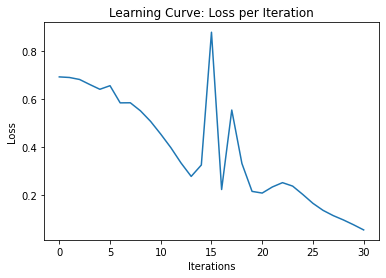

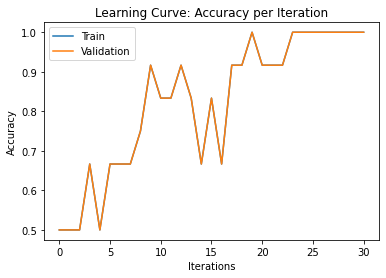

In [26]:
# Write your code here. Remember to include your results so that we can
# see that your model attains a high training accuracy. 
model_6_channels = CNNChannel(n=32)
model_6_channels.to(device)

train_data_split, validation_data_split = train_data[:2], train_data[:2]

try_train = run_pytorch_gradient_descent(model_6_channels, train_data_split, validation_data_split, batch_size=12, learning_rate=2e-4,
                                 weight_decay=0, max_iters=30, checkpoint_path=None)

plot_learning_curve(*try_train)

Epoch 0. [Val pos Acc 0%] [Val neg Acc 100%] [Train pos Acc 0%] [Train neg Acc 100%] [Loss 0.693529]
Epoch 1. [Val pos Acc 100%] [Val neg Acc 0%] [Train pos Acc 100%] [Train neg Acc 0%] [Loss 0.692350]
Epoch 2. [Val pos Acc 0%] [Val neg Acc 100%] [Train pos Acc 0%] [Train neg Acc 100%] [Loss 0.690811]
Epoch 3. [Val pos Acc 0%] [Val neg Acc 100%] [Train pos Acc 0%] [Train neg Acc 100%] [Loss 0.688538]
Epoch 4. [Val pos Acc 100%] [Val neg Acc 33%] [Train pos Acc 100%] [Train neg Acc 33%] [Loss 0.684994]
Epoch 5. [Val pos Acc 100%] [Val neg Acc 100%] [Train pos Acc 100%] [Train neg Acc 100%] [Loss 0.680210]
Epoch 6. [Val pos Acc 100%] [Val neg Acc 100%] [Train pos Acc 100%] [Train neg Acc 100%] [Loss 0.673268]
Epoch 7. [Val pos Acc 100%] [Val neg Acc 67%] [Train pos Acc 100%] [Train neg Acc 67%] [Loss 0.662570]
Epoch 8. [Val pos Acc 33%] [Val neg Acc 100%] [Train pos Acc 33%] [Train neg Acc 100%] [Loss 0.646457]
Epoch 9. [Val pos Acc 100%] [Val neg Acc 33%] [Train pos Acc 100%] [Train neg

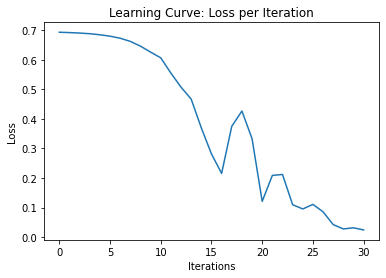

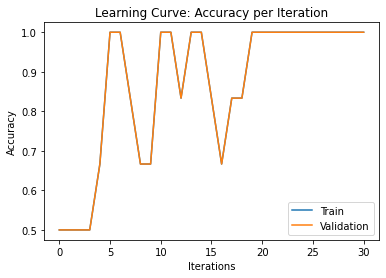

In [41]:
model_3_channels = CNN(n=20)
model_3_channels.to(device)

train_data_split, validation_data_split = train_data[:1], train_data[:1]

try_train_3_channels = run_pytorch_gradient_descent(model_3_channels, train_data_split, validation_data_split, batch_size=6, learning_rate=1e-4,
                                 weight_decay=2e-8, max_iters=30, checkpoint_path=None)

plot_learning_curve(*try_train_3_channels)

### Part (c) -- 8%

Train your models from Q2(a) and Q2(b). Change the values of a few 
hyperparameters, including the learning rate, batch size, choice of $n$, and 
the kernel size. You do not need to check all values for all hyperparameters. Instead, try to make big changes to see how each change affect your scores.
(try to start with finding a resonable learning rate for each network, that start changing the other parameters, the first network might need bigger $n$ and kernel size)

In this section, explain how you tuned your hyperparameters.

In [27]:
import gc as gc

def get_cnn_channel_hyper_params():
  lr = [1e-4, 5e-5]
  wd = [0]
  bs = [200]
  n = [24, 32]

  return lr, wd, bs, n

def get_cnn_hyper_params():
  lr = [1e-4, 5e-5]
  wd = [0]
  bs = [200]
  n = [24, 32]

  return lr, wd, bs, n


def find_best_model(model_type, model_class, lr, wd, bs, n):
  train_data_split, validation_data_split = train_data[15:], train_data[:15]
  best_val_acc = 0
  counter = 0
  for init_n in n:
    for batch_size in bs:
      for w_decay in wd:
        for l_rate in lr:
          counter = counter + 1
          model_count = str(counter)
          model = model_class(init_n)
          model.to(device)
          checkpoint_path = '/content/gdrive/My Drive/MSc/Courses/Into to Deep Learnig/Assignments/3/model'+model_count+'_best_'+ model_type + '_t-{}.pk'
          temp_learning_curve_info = run_pytorch_gradient_descent(model, train_data_split, validation_data_split, 
                                                                   batch_size=batch_size, learning_rate=l_rate,
                                                                   weight_decay=w_decay, max_iters=30, checkpoint_path=checkpoint_path)
          print("Model with: learning rate = {:f}, batch size = {:.0f}, weight_decay = {}, n_initial = {} val accuracy = {:.2f} %".
                format(l_rate, batch_size, w_decay, init_n, (np.mean(temp_learning_curve_info[4][-1]) * 100)))
          plot_learning_curve(*temp_learning_curve_info)
          if temp_learning_curve_info[3][-1] > best_val_acc:
            best_val_acc = np.mean(temp_learning_curve_info[4][-1])
            best_learning_curve_info = temp_learning_curve_info
            best_model = model
            best_model_lr = l_rate
            best_model_bs = batch_size
            best_model_wd = w_decay
            best_model_n = init_n

          _ = gc.collect()

  print("best model found, number = "+ model_count + " with learning rate = {}, batch size = {}, weight decay = {}, init_n = {}, val accuracy = {:.2f}%".
        format(best_model_lr, best_model_bs, best_model_wd, init_n, best_val_acc *100))
  return best_model, best_learning_curve_info

Epoch 0. [Val pos Acc 7%] [Val neg Acc 96%] [Train pos Acc 7%] [Train neg Acc 97%] [Loss 0.693543]
Epoch 1. [Val pos Acc 62%] [Val neg Acc 69%] [Train pos Acc 72%] [Train neg Acc 57%] [Loss 0.689972]
Epoch 2. [Val pos Acc 76%] [Val neg Acc 58%] [Train pos Acc 81%] [Train neg Acc 55%] [Loss 0.679593]
Epoch 3. [Val pos Acc 100%] [Val neg Acc 36%] [Train pos Acc 99%] [Train neg Acc 33%] [Loss 0.657512]
Epoch 4. [Val pos Acc 80%] [Val neg Acc 60%] [Train pos Acc 85%] [Train neg Acc 59%] [Loss 0.643513]
Epoch 5. [Val pos Acc 69%] [Val neg Acc 73%] [Train pos Acc 72%] [Train neg Acc 75%] [Loss 0.625288]
Epoch 6. [Val pos Acc 98%] [Val neg Acc 44%] [Train pos Acc 95%] [Train neg Acc 56%] [Loss 0.612247]
Epoch 7. [Val pos Acc 80%] [Val neg Acc 71%] [Train pos Acc 78%] [Train neg Acc 76%] [Loss 0.581994]
Epoch 8. [Val pos Acc 89%] [Val neg Acc 67%] [Train pos Acc 85%] [Train neg Acc 71%] [Loss 0.559102]
Epoch 9. [Val pos Acc 98%] [Val neg Acc 56%] [Train pos Acc 91%] [Train neg Acc 64%] [Loss 0

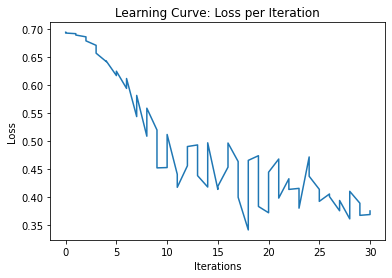

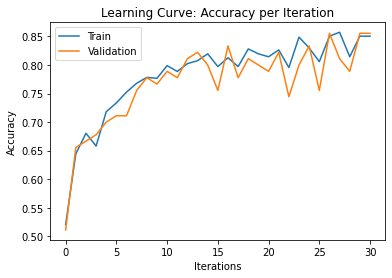

Epoch 0. [Val pos Acc 100%] [Val neg Acc 0%] [Train pos Acc 100%] [Train neg Acc 0%] [Loss 0.694245]
Epoch 1. [Val pos Acc 4%] [Val neg Acc 100%] [Train pos Acc 1%] [Train neg Acc 100%] [Loss 0.690300]
Epoch 2. [Val pos Acc 2%] [Val neg Acc 100%] [Train pos Acc 0%] [Train neg Acc 100%] [Loss 0.686480]
Epoch 3. [Val pos Acc 11%] [Val neg Acc 96%] [Train pos Acc 4%] [Train neg Acc 100%] [Loss 0.679655]
Epoch 4. [Val pos Acc 42%] [Val neg Acc 78%] [Train pos Acc 32%] [Train neg Acc 89%] [Loss 0.672425]
Epoch 5. [Val pos Acc 40%] [Val neg Acc 78%] [Train pos Acc 28%] [Train neg Acc 91%] [Loss 0.658657]
Epoch 6. [Val pos Acc 62%] [Val neg Acc 78%] [Train pos Acc 47%] [Train neg Acc 81%] [Loss 0.639289]
Epoch 7. [Val pos Acc 80%] [Val neg Acc 60%] [Train pos Acc 69%] [Train neg Acc 70%] [Loss 0.627413]
Epoch 8. [Val pos Acc 78%] [Val neg Acc 71%] [Train pos Acc 66%] [Train neg Acc 74%] [Loss 0.574004]
Epoch 9. [Val pos Acc 76%] [Val neg Acc 84%] [Train pos Acc 71%] [Train neg Acc 77%] [Loss 

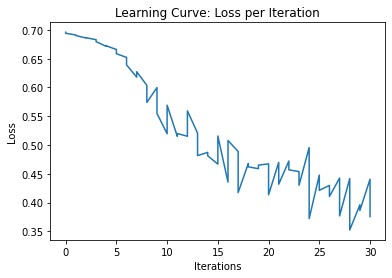

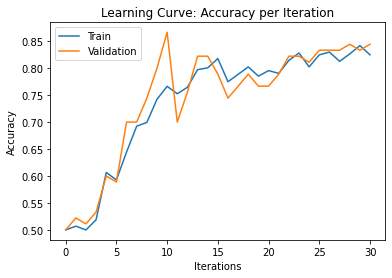

Epoch 0. [Val pos Acc 0%] [Val neg Acc 100%] [Train pos Acc 1%] [Train neg Acc 100%] [Loss 0.694004]
Epoch 1. [Val pos Acc 100%] [Val neg Acc 24%] [Train pos Acc 99%] [Train neg Acc 19%] [Loss 0.687522]
Epoch 2. [Val pos Acc 91%] [Val neg Acc 47%] [Train pos Acc 94%] [Train neg Acc 46%] [Loss 0.671241]
Epoch 3. [Val pos Acc 100%] [Val neg Acc 47%] [Train pos Acc 93%] [Train neg Acc 56%] [Loss 0.640896]
Epoch 4. [Val pos Acc 100%] [Val neg Acc 20%] [Train pos Acc 99%] [Train neg Acc 20%] [Loss 0.593393]
Epoch 5. [Val pos Acc 24%] [Val neg Acc 93%] [Train pos Acc 16%] [Train neg Acc 97%] [Loss 0.552812]
Epoch 6. [Val pos Acc 98%] [Val neg Acc 42%] [Train pos Acc 96%] [Train neg Acc 55%] [Loss 0.555383]
Epoch 7. [Val pos Acc 96%] [Val neg Acc 44%] [Train pos Acc 96%] [Train neg Acc 54%] [Loss 0.598890]
Epoch 8. [Val pos Acc 51%] [Val neg Acc 89%] [Train pos Acc 51%] [Train neg Acc 91%] [Loss 0.524145]
Epoch 9. [Val pos Acc 87%] [Val neg Acc 56%] [Train pos Acc 90%] [Train neg Acc 68%] [Lo

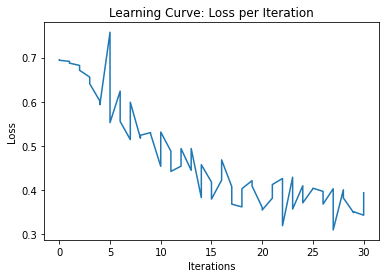

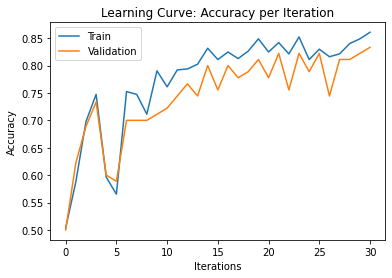

Epoch 0. [Val pos Acc 78%] [Val neg Acc 40%] [Train pos Acc 72%] [Train neg Acc 39%] [Loss 0.692810]
Epoch 1. [Val pos Acc 2%] [Val neg Acc 100%] [Train pos Acc 0%] [Train neg Acc 100%] [Loss 0.689593]
Epoch 2. [Val pos Acc 4%] [Val neg Acc 100%] [Train pos Acc 0%] [Train neg Acc 100%] [Loss 0.687430]
Epoch 3. [Val pos Acc 11%] [Val neg Acc 98%] [Train pos Acc 18%] [Train neg Acc 98%] [Loss 0.685957]
Epoch 4. [Val pos Acc 24%] [Val neg Acc 98%] [Train pos Acc 31%] [Train neg Acc 95%] [Loss 0.672573]
Epoch 5. [Val pos Acc 13%] [Val neg Acc 100%] [Train pos Acc 23%] [Train neg Acc 97%] [Loss 0.653458]
Epoch 6. [Val pos Acc 76%] [Val neg Acc 84%] [Train pos Acc 70%] [Train neg Acc 79%] [Loss 0.624370]
Epoch 7. [Val pos Acc 33%] [Val neg Acc 91%] [Train pos Acc 48%] [Train neg Acc 91%] [Loss 0.554583]
Epoch 8. [Val pos Acc 93%] [Val neg Acc 60%] [Train pos Acc 90%] [Train neg Acc 63%] [Loss 0.556851]
Epoch 9. [Val pos Acc 71%] [Val neg Acc 80%] [Train pos Acc 71%] [Train neg Acc 81%] [Loss

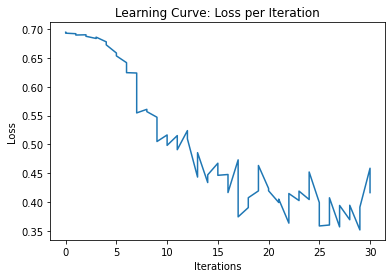

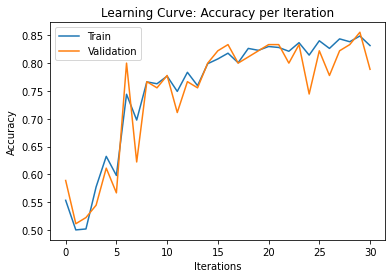

best model found, number = 4 with learning rate = 0.0001, batch size = 200, weight decay = 0, init_n = 32, val accuracy = 83.33%


In [14]:
_ = gc.collect()
lr, wd, bs, n = get_cnn_channel_hyper_params()
best_model, best_learning_curve_info = find_best_model('6C', CNNChannel, lr, wd, bs, n)

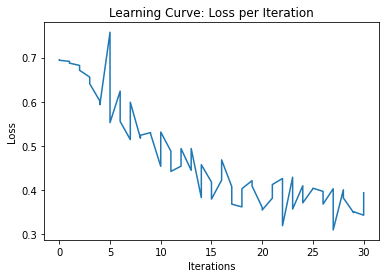

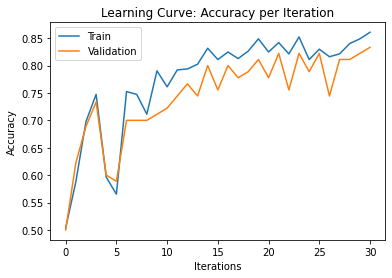

In [15]:
plot_learning_curve(*best_learning_curve_info)

In [ ]:
_ = gc.collect()
lr, wd, bs, n = get_cnn_hyper_params()
best_model_first, best_learning_curve_info_first = find_best_model('3C', CNN, lr, wd, bs, n)
plot_learning_curve(*best_learning_curve_info_first)


**Write your explanation here:**

_Note: We searched for the best model by only changing the learning rate and 'n' (controls the amount of filters in each convolutional layer) parametrs due to the resources limitation in colab._  

####**6 Channels Model:**  
We can notice in the curves that were plotted during the best model search that the small learning rate cause less noise in the train loss, and the n (controls the channels per convolutional layer output) increases the reachable accuracy in the defined epochs which can be explained by increasing the amount of learnabl parameters (each output channel created by different filter which increse the amount of filters that contains learnable parameters).
  
    
####**3 Channels Model**  


In [ ]:
# Include the training curves for the two models.

### Part (d) -- 4%

Include your training curves for the **best** models from each of Q2(a) and Q2(b).
These are the models that you will use in Question 4.

In [ ]:
# Include the training curves for the two models.

## Question 4. Testing (15%)

### Part (a) -- 7%

Report the test accuracies of your **single best** model,
separately for the two test sets.
Do this by choosing the  model
architecture that produces the best validation accuracy. For instance,
if your model attained the
best validation accuracy in epoch 12, then the weights at epoch 12 is what you should be using
to report the test accuracy.

In [ ]:
# Write your code here. Make sure to include the test accuracy in your report

### Part (b) -- 4%

Display one set of men's shoes that your model correctly classified as being
from the same pair.

If your test accuracy was not 100% on the men's shoes test set,
display one set of inputs that your model classified incorrectly.


### Part (c) -- 4%

Display one set of women's shoes that your model correctly classified as being
from the same pair.

If your test accuracy was not 100% on the women's shoes test set,
display one set of inputs that your model classified incorrectly.